## Pseudo-Spectral Projection

This tutorial uses the same example as the [example introduction](./example_introduction.ipynb).
In other words:

In [1]:
import numpy
from matplotlib import pyplot
import chaospy
from chaospy.example import (
    coordinates, exponential_model, distribution)

Pseudo-spectral projection method is one of two non-intrusive polynomial chaos expansion methods.
(The other being point collocation method.)
In a nutshell it can be performed as follows:

* Generate nodes $Q_1, ..., Q_N$ and weights $W_1, ..., W_N$ from a quadrature integration scheme.
* Use nodes to create model predictions $U_1, ..., U_N$.
* Select an expansion or polynomials $P_1, ..., P_M$, typically orthogonal (with respect to the probability distribution).
* Calculate Fourier coefficients $c_1, ..., c_M$.
* Analyze model approximation $u(t; I, R) = \sum_m c_m(t) P_n(I, R)$ instead of actual model solver. 

### Create Polynomial Expansion

In [2]:
polynomial_order = 4
polynomial_expansion = chaospy.generate_expansion(
    polynomial_order, distribution)
polynomial_expansion[:6].round(4)

polynomial([1.0, q1-0.15, q0-1.5, q1**2-0.3*q1+0.0217,
            q0*q1-1.5*q1-0.15*q0+0.225, q0**2-3.0*q0+2.21])

### Create Quadrature Nodes and Weights

In addition we need abscissas and weights from an quadrature scheme:

In [3]:
quadrature_order = 8
abscissas, weights = chaospy.generate_quadrature(
    quadrature_order, distribution, rule="gaussian")

abscissas[:, ::40].round(12), weights[::40].round(12)

(array([[0.59745083, 1.5       , 2.40254917],
        [0.10159199, 0.15      , 0.19840801]]),
 array([9.08072000e-07, 6.70962499e-02, 9.08072000e-07]))

(0.5, 2.5, 0.1, 0.2)

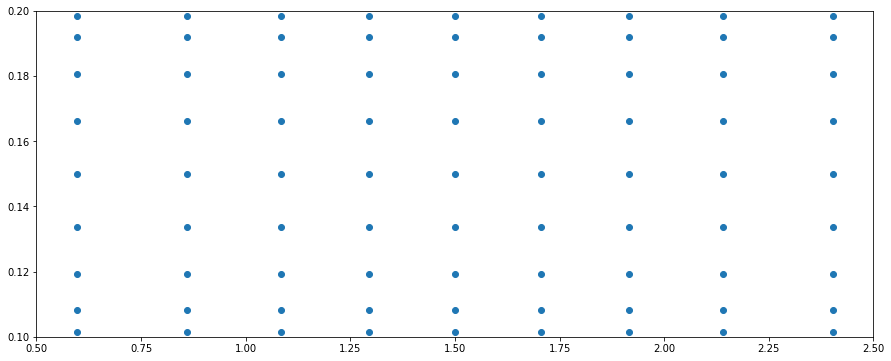

In [4]:
pyplot.rc("figure", figsize=[15, 6])
pyplot.scatter(*abscissas)
pyplot.axis([0.5, 2.5, 0.1, 0.2])

### Creating Model Approximation

These can then be used to create an polynomial approximation as follows:

In [5]:
evaluations = [
    exponential_model(abscissa) for abscissa in abscissas.T
]
foo_approx = chaospy.fit_quadrature(
    polynomial_expansion, abscissas, weights, evaluations)
foo_approx[:5].round(3)

polynomial([q0, -0.01*q0*q1+q0, -0.02*q0*q1+q0, -0.03*q0*q1+q0,
            0.001*q0*q1**2-0.04*q0*q1+q0])

### Calculate Descriptive Statistics

The expected value and variance is calculated as before:

(array([1.5   , 1.4977, 1.4955, 1.4933]),
 array([0.2   , 0.1997, 0.1994, 0.1991]))

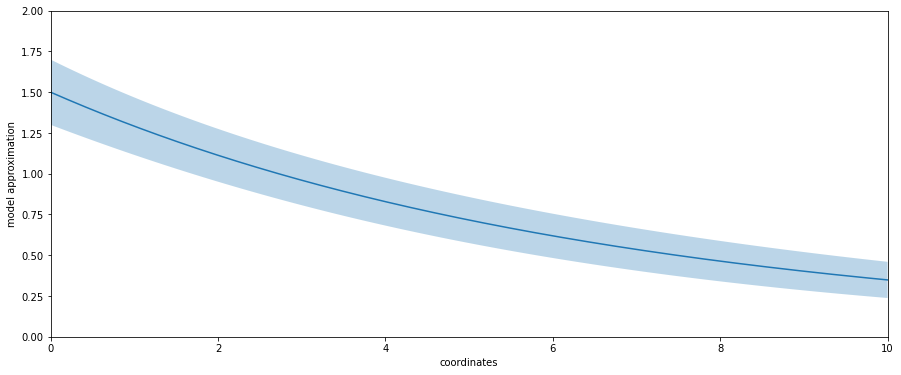

In [6]:
expected = chaospy.E(foo_approx, distribution)
std = chaospy.Std(foo_approx, distribution)

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.axis([0, 10, 0, 2])
pyplot.fill_between(
    coordinates, expected-std, expected+std, alpha=0.3)
pyplot.plot(coordinates, expected)

expected[:4].round(4), std[:4].round(4)

### Error Analysis

It is hard to assess how well these models are doing from the final estimation alone.
They look about the same.
So to compare results, we do error analysis.
To do so, we use the reference analytical solution and error function as defined in  [example introduction](./example_introduction.ipynb).

In [7]:
from chaospy.example import error_mean, error_variance

assert error_mean(expected) < 1e-10
assert error_variance(std**2) < 1e-10

The analysis can be performed as follows:

In [8]:
# Estimate mean and variance for various number of samples
polynomial_orders = list(range(2, 6))
    
sample_sizes = []
errors_mean = []
errors_variance = []
for order in polynomial_orders:
        
    # Perform analysis for a specific order
    nodes, weights = chaospy.generate_quadrature(
        order, distribution, rule="gaussian")
    evaluations = [
        exponential_model(node) for node in nodes.T]
    polynomial_expansion = chaospy.generate_expansion(
        order, distribution)
    model_approximation = chaospy.fit_quadrature(
        polynomial_expansion, nodes, weights, evaluations)
        
    # Store results
    sample_sizes.append((order+1)**2)
    errors_mean.append(error_mean(
        chaospy.E(model_approximation, distribution)))
    errors_variance.append(error_variance(
        chaospy.Var(model_approximation, distribution)))

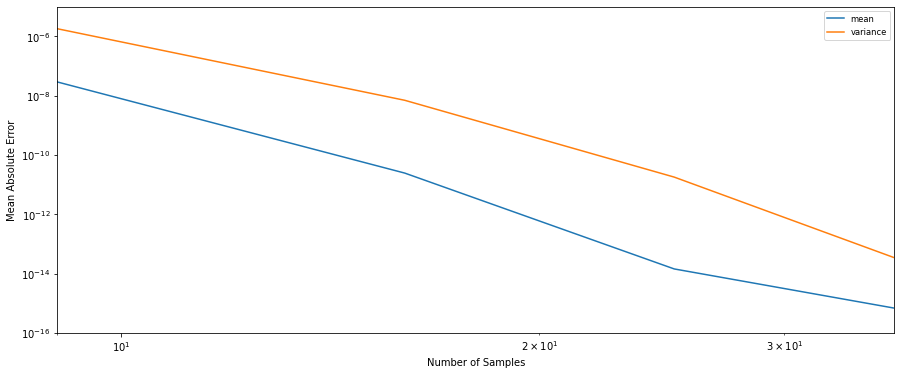

In [9]:
# Error plot for mean
pyplot.loglog(sample_sizes, errors_mean, label="mean")
    
# Error plot for variance
pyplot.loglog(sample_sizes, errors_variance, label="variance")
    
# Make plot pretty
pyplot.axis([min(sample_sizes), max(sample_sizes), 1e-16, 1e-5])
pyplot.xlabel("Number of Samples")
pyplot.ylabel("Mean Absolute Error")
pyplot.legend()
    
pyplot.show()